In [ ]:
!pip install spacy

In [112]:
import pandas as pd

#импортируем файл с данными
df = pd.read_csv('/content/final_lyrics')
#начальная предобработка
df['lyrics_clean'] = df['lyrics'].replace(r'[^\w\s]',' ',regex=True).replace(r'\s+',' ',regex=True).str.lower()

# Анализ текста песен

In [113]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


# Загрузим модель для английского языка
nlp = spacy.load("en_core_web_sm")
custom_stop_words = [
    "gobble", "bidee", "ve", "ll", '' "oh", "ya", "ain", "don", "didn", "te", "fasule", "tay", "ce",
    "la", "em", "di", "il", "er", "de", "to", "ba", "da", "doo", "zee", "boo", "mmm", "ho", "ti", "to"]

# Расширим стоп-слова
STOP_WORDS.update(custom_stop_words)

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        if not token.is_stop and token.is_alpha and len(token) > 1:
            lemmas.append(token.lemma_)
    return lemmas

In [114]:
# Применим лемматизацию к предобработанному столбцу с текстами песен
df['lemmatized'] = df['lyrics_clean'].apply(lemmatize_text)


In [115]:
import spacy
from collections import defaultdict
from nltk import FreqDist


# Собираем все слова из колонки 'lemmatized'
all_words = [word for row in df['lemmatized'] for word in row]

# Обрабатываем текст через spaCy
doc = nlp(" ".join(all_words))

# Создаем распределение по частям речи
pos_distribution = defaultdict(list)

for token in doc:
    pos = token.pos_  # Универсальные теги (NOUN, VERB, ADJ, ADV и т.д.)
    pos_distribution[pos].append(token.text)

# Упрощаем теги
simplified_mapping = {
    "NOUN": "noun",
    "VERB": "verb",
    "ADJ": "adj",
    "ADV": "adv",
    # Остальные категории объединяем в 'other'
}

simplified_distribution = defaultdict(list)
for pos, words in pos_distribution.items():
    simplified_pos = simplified_mapping.get(pos, "other")
    simplified_distribution[simplified_pos].extend(words)


## Проведем анализ по частям речи

In [116]:
# Топ 20 существительных
top_noun = FreqDist(simplified_distribution['noun']).most_common(20)
print(top_noun)
# Топ 20 глаголов
top_verb = FreqDist(simplified_distribution['verb']).most_common(20)
print(top_verb)
# Топ 20 прилагательных
top_adj = FreqDist(simplified_distribution['adj']).most_common(20)
print(top_adj)
# Топ 20 наречий
top_adv = FreqDist(simplified_distribution['adv']).most_common(20)
print(top_adv)

[('love', 208), ('way', 98), ('heart', 89), ('dream', 83), ('day', 69), ('time', 68), ('life', 61), ('world', 58), ('baby', 52), ('night', 48), ('thing', 47), ('snow', 46), ('spook', 40), ('boom', 39), ('wheel', 39), ('home', 36), ('people', 34), ('eye', 34), ('air', 34), ('song', 32)]
[('let', 125), ('go', 117), ('get', 109), ('know', 80), ('come', 76), ('find', 60), ('say', 50), ('hear', 44), ('sing', 43), ('see', 39), ('tell', 39), ('look', 37), ('think', 36), ('feel', 35), ('leave', 31), ('love', 28), ('fly', 26), ('hold', 24), ('fall', 24), ('make', 23)]
[('good', 61), ('old', 52), ('sweet', 43), ('dear', 40), ('little', 38), ('funny', 27), ('long', 26), ('young', 26), ('blue', 26), ('wonderful', 26), ('middle', 25), ('true', 24), ('big', 22), ('happy', 22), ('warm', 19), ('open', 18), ('bright', 18), ('lovely', 16), ('low', 14), ('cold', 14)]
[('away', 46), ('long', 27), ('right', 23), ('someday', 19), ('way', 15), ('far', 12), ('soon', 12), ('pretty', 11), ('forever', 8), ('well

## Визуализируем самые частотные слова по частям речи

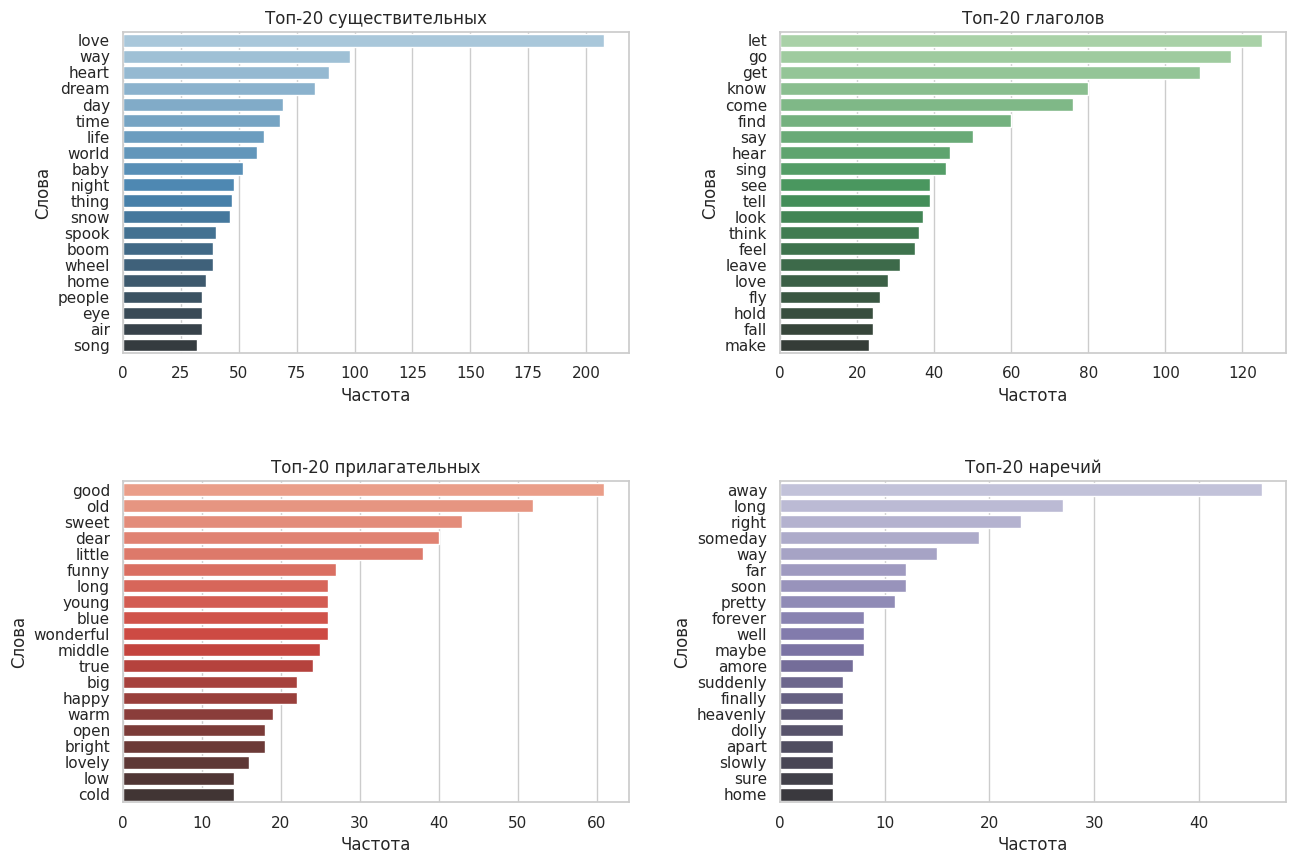

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns


# Настройка стиля
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3) # Добавим свободное пространство между графиками

# Функция для построения графиков
def plot_top_words(data, title, palette, position):
    plt.subplot(2, 2, position)
    words, counts = zip(*data)
    sns.barplot(
        x=list(counts),
        y=list(words),
        hue=list(words),
        palette=palette,
        legend=False,
        dodge=False
    )
    plt.title(title)
    plt.xlabel("Частота")
    plt.ylabel('Слова')

# Построение графиков
plot_top_words(top_noun, "Топ-20 существительных", "Blues_d", 1)
plot_top_words(top_verb, "Топ-20 глаголов", "Greens_d", 2)
plot_top_words(top_adj, "Топ-20 прилагательных", "Reds_d", 3)
plot_top_words(top_adv, "Топ-20 наречий", "Purples_d", 4)


## Характерные для исполнителей слова

---
**Небольшая теоретическая справка про TF-IDF анализ**
*TF (Term Frequency)*:

Относительная частота слова в документе:
TF = (число вхождений слова в документе) / (общее число слов в документе).

*IDF (Inverse Document Frequency)*:

Мера редкости слова в корпусе:
IDF = log( (число документов) / (число документов, содержащих слово) ).

TF-IDF:
 - TF * IDF — чем выше значение, тем важнее слово для документа в контексте всего корпуса.

---

In [118]:
# Объединим леммы в строки
df['lemmatized_text'] = df['lemmatized'].apply(lambda x: ' '.join(x))

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Группировка по исполнителям и объединение в одну строку
grouped = df.groupby('artist')['lemmatized_text'].agg(' '.join).reset_index()

# Создание TF-IDF матрицы
vectorizer = TfidfVectorizer(max_features=1000, stop_words = list(STOP_WORDS))   # Не забываем про расширенный набор стоп-слов
tfidf_matrix = vectorizer.fit_transform(grouped['lemmatized_text'])

# Датафрейм с весами TF-IDF
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=grouped['artist']
)

# Функция для извлечения топ-слов
def get_top_artist_words(artist, n=10):
    return tfidf_df.loc[artist].nlargest(n).to_dict()


## Визуализируем характерные слова

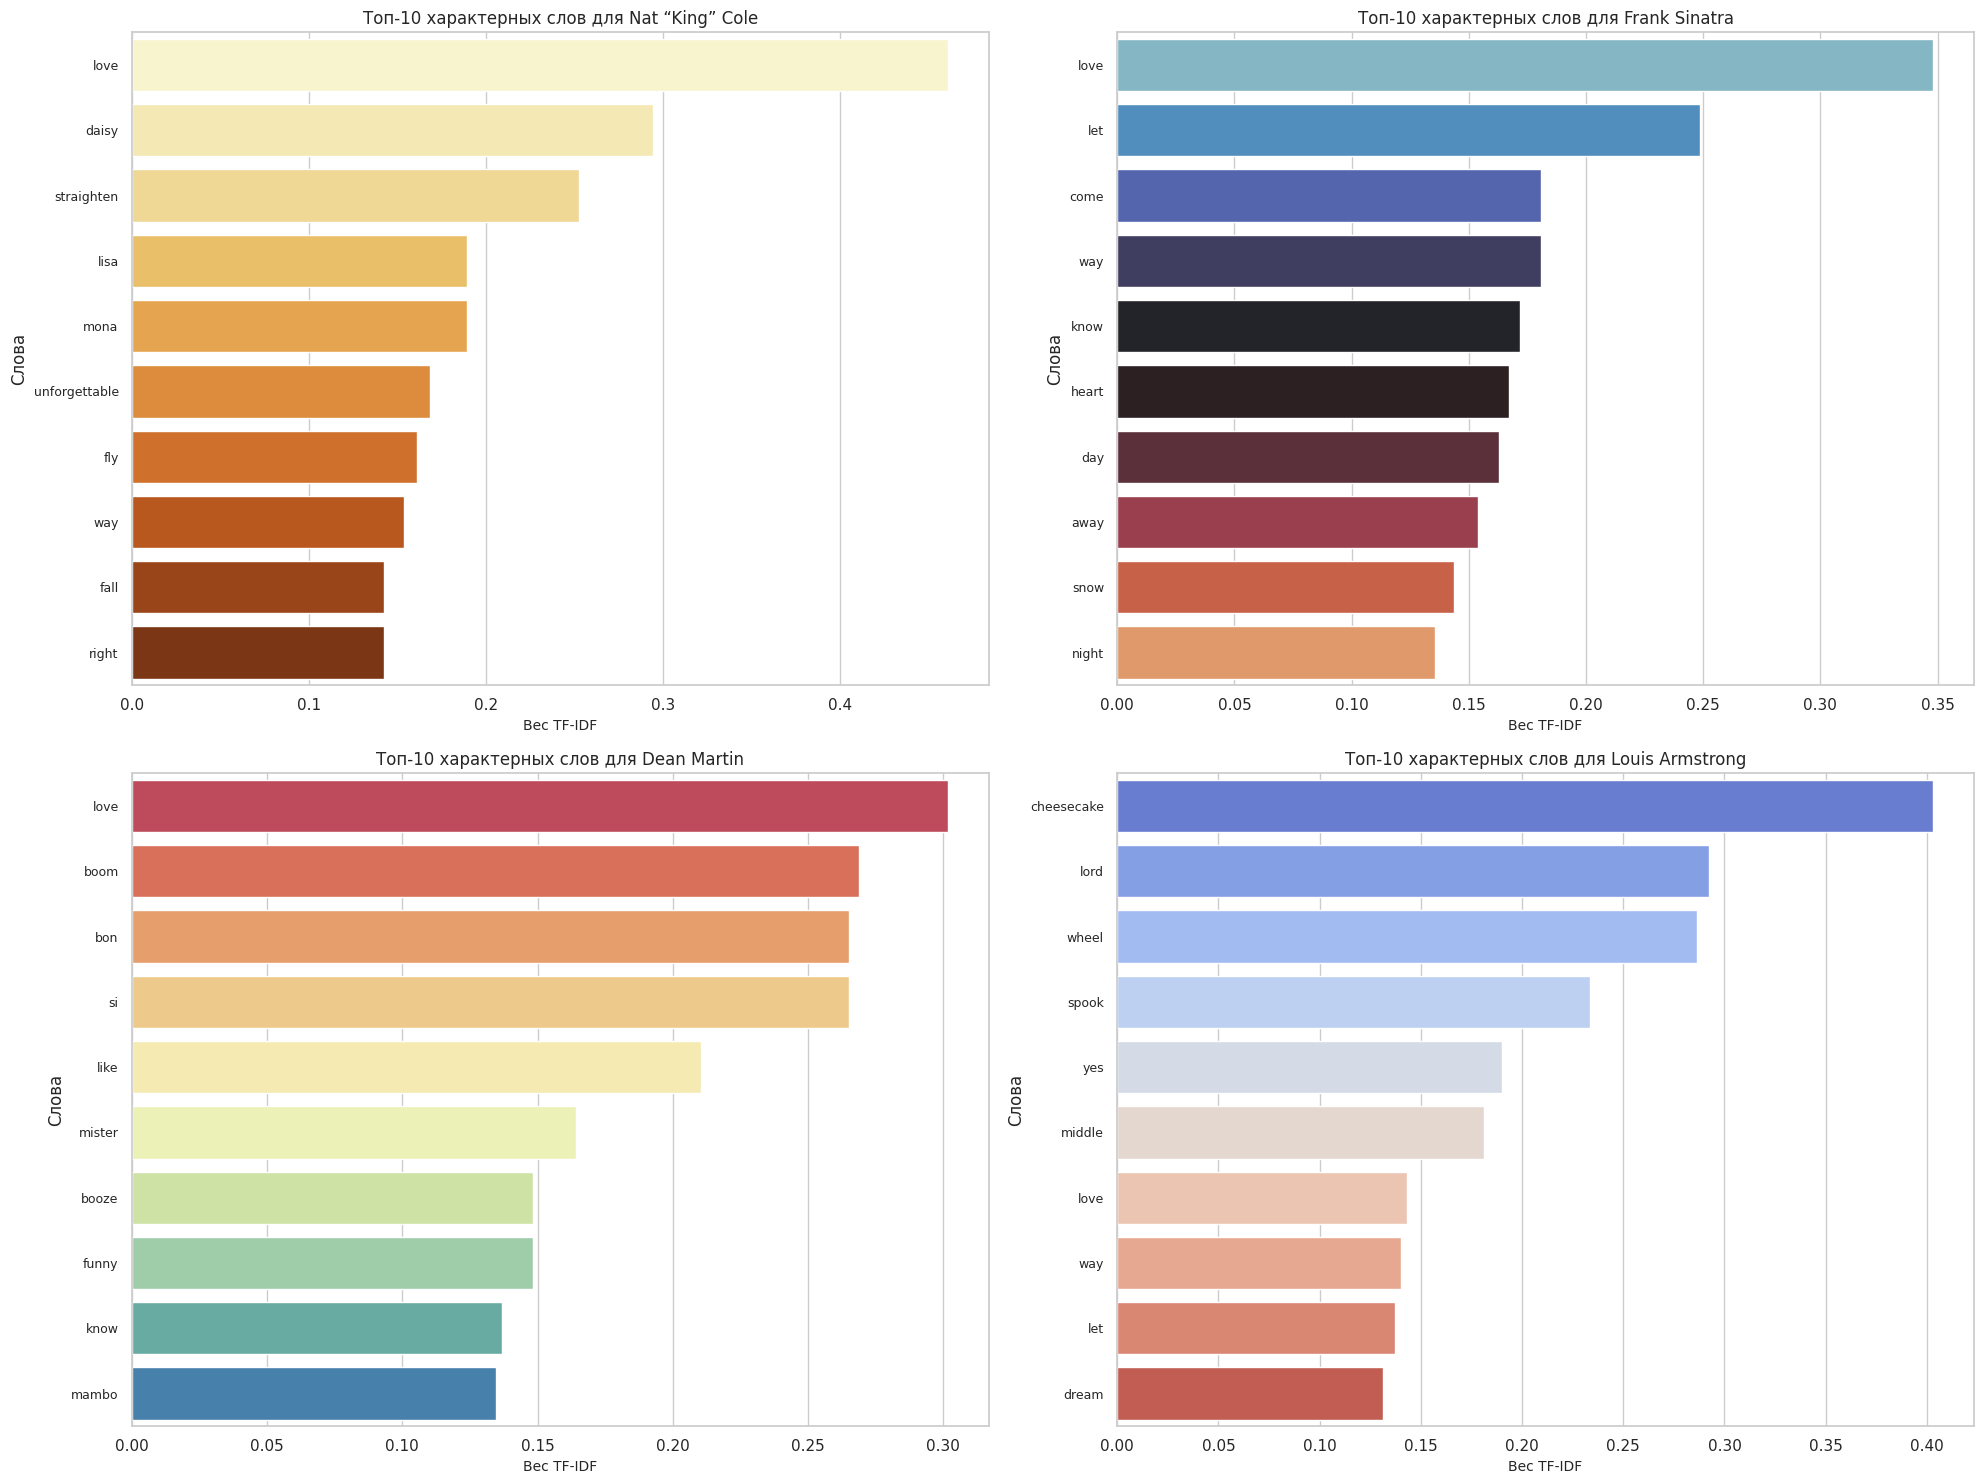

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 15))  # Общий размер для всех субграфиков

# Создаем сетку 2x2 для 4 графиков
plt.subplots_adjust(hspace=0.4, wspace=0.4) # Свободное пространство между графиками

def plot_artist_tfidf(artist, palette, position, n=10):
    plt.subplot(2, 2, position)
    top_words = tfidf_df.loc[artist].nlargest(n) # количество максимально встречающихся слов

    # параметры barplot
    sns.barplot(
        x=top_words.values,           # Выцепим вес tf-idf
        y=top_words.index,            # Выцепим слово
        hue=top_words.index,
        palette=palette,
        legend=False,
        dodge=False                   # Выключаем наложение баров/столбцов
    )

    plt.title(f"Топ-{n} характерных слов для {artist}", fontsize=12)
    plt.xlabel("Вес TF-IDF", fontsize=10)
    plt.ylabel("Слова")
    plt.tick_params(axis='y', labelsize=9)

# Рисуем все графики на одной фигуре
plot_artist_tfidf('Nat “King” Cole', 'YlOrBr', 1)
plot_artist_tfidf('Frank Sinatra', 'icefire', 2)
plot_artist_tfidf('Dean Martin', 'Spectral', 3)
plot_artist_tfidf('Louis Armstrong', 'coolwarm', 4)

plt.tight_layout()
plt.show()

## Облако слов по исполнителю/всем исполнителям сразу

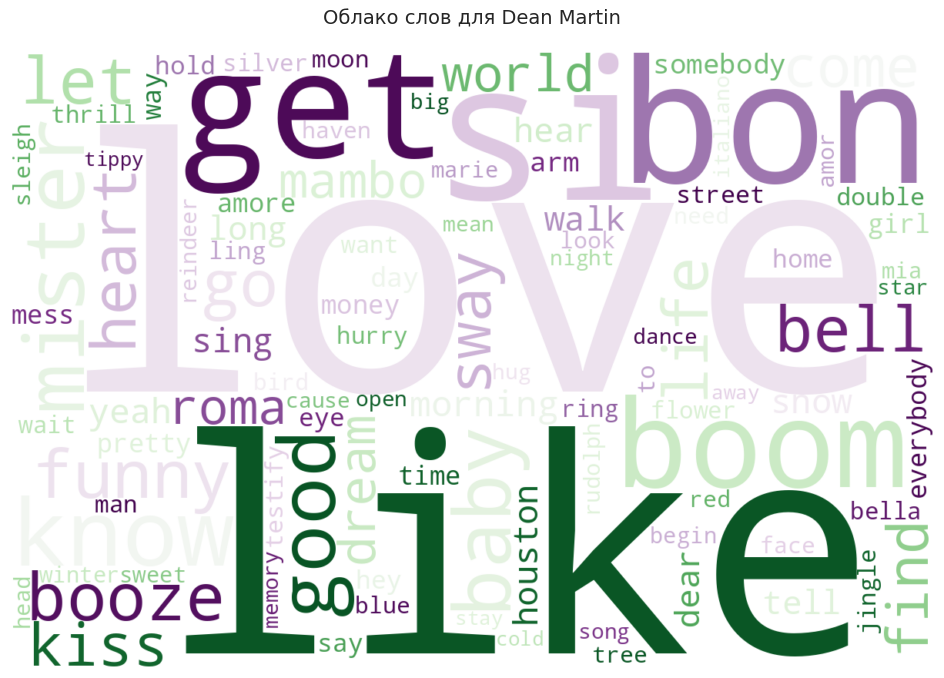

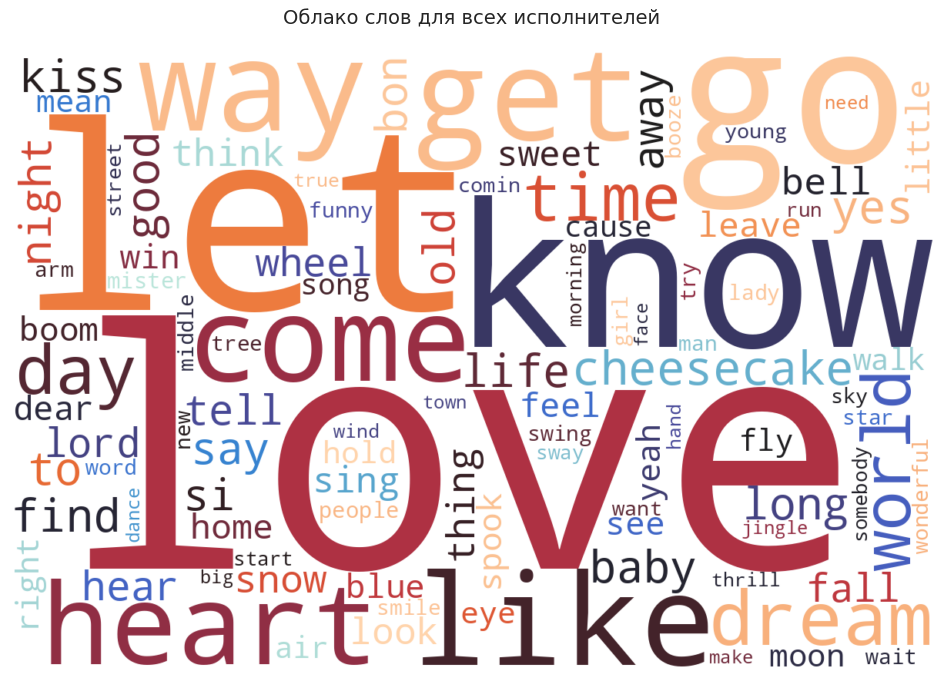

In [121]:
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def generate_wordcloud(artist_name=None, df=None,
                       background_color='white',
                       colormap=None,
                       colormap_list=['viridis', 'plasma', 'magma', 'cividis', 'cool', 'twilight_shifted', 'icefire'],
                       max_words=100,
                       figsize=(12, 8)):
    """
    Генерирует облако слов со случайной цветовой схемой из списка.

    Параметры:
    - artist_name: Имя исполнителя, если не указано выводится облако слов по всем исполнителям
    - colormap_list: список допустимых цветовых схем.
    - colormap: если указан, будет использован вместо случайного выбора.
    """
    # Выбор цветовой схемы
    if colormap is None:
        if colormap_list:
            colormap = random.choice(colormap_list)
        else:
            colormap = 'viridis'  # Дефолтное значение
    # Фильтрация данных
    if artist_name:
        data = df[df['artist'] == artist_name]['lemmatized_text'] # Фильтр по исполнителю
        if data.empty:
            raise ValueError(f"Исполнитель '{artist_name}' не найден в данных.")
    else:
        data = df['lemmatized_text']

    # Объединение текстов в одну строку
    all_text = ' '.join(data.astype(str))

    # Подсчет частоты слов
    word_freq = Counter(all_text.split())

    # Генерация облака
    wordcloud = WordCloud(
        width=figsize[0] * 100,                 # настроим ширину фигуры
        height=figsize[1] * 100,                # настроим высоту фигуры
        background_color=background_color,      # заливка фона
        colormap=colormap,                      # выбор цветовой палитры
        max_words=max_words                     # максимальное количество слов
    ).generate_from_frequencies(word_freq)      # сгенирируем облако на основе частот встречаемости

    # Визуализация
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear') # отобразим облако со сглаживанием
    plt.axis('off')
    if artist_name:
        plt.title(f'Облако слов для {artist_name}', fontsize=14, pad=20)
    else:
        plt.title('Облако слов для всех исполнителей', fontsize=14, pad=20)
    plt.show()

# Пример использования для Дина Мартина
generate_wordcloud(artist_name='Dean Martin', df=df)
# Для всех исполнителей
generate_wordcloud(df=df)

# Анализ продолжительности треков

In [122]:
import pandas as pd

# Сделаем сводную таблицу с посчитанной средней, медианной, минимальной и максимальной продолжительностью
dur_df = df.groupby('artist')['duration'].agg(
    mean_duration='mean',
    median_duration='median',
    min_duration='min',
    max_duration='max'
).reset_index()
dur_df

,artist,mean_duration,median_duration,min_duration,max_duration
0,Dean Martin,161.440,152.0,117,317
1,Frank Sinatra,198.620,175.5,125,526
2,Louis Armstrong,215.740,192.0,106,524
3,Nat “King” Cole,172.125,176.5,106,211


## Распределение треков по продолжительности

In [123]:
import plotly.express as px


fig = px.histogram(
    df,
    x='duration',
    color='artist',
    nbins=20,
    opacity=0.7,
    barmode='group',
    title='Распределение длительности треков по исполнителям',
    labels={'duration': 'Длительность (секунды)', 'count': 'Количество треков'}
)

fig.update_layout(
    plot_bgcolor='white',
    hoverlabel=dict(bgcolor='white'), # сделаем заливку фона подсказок белой
    legend_title='Исполнитель',
    title_x=0.5,
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.update_traces(
    hovertemplate='Длительность: %{x:.1f} секунд<br>Треков: %{y}' # <br> - элемент переноса строки в html, чтобы при наведении подсказка отображалась приятнее
)

fig.show()

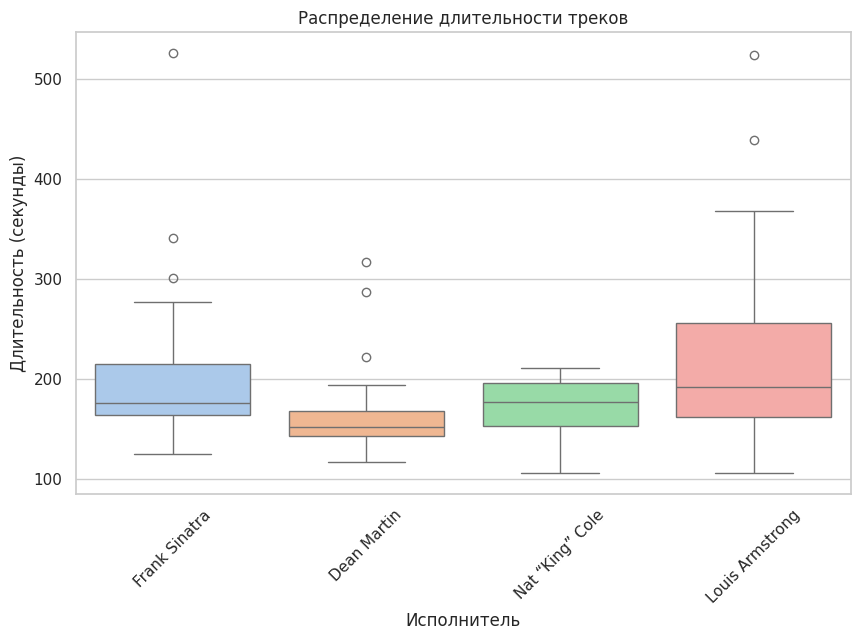

In [124]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='artist',
    hue ='artist',
    y='duration',
    palette='pastel',
    showfliers=True, # Показать выбросы
    legend = False
)
plt.title("Распределение длительности треков")
plt.xlabel("Исполнитель")
plt.ylabel("Длительность (секунды)")
plt.xticks(rotation=45)
plt.show()

## Самые длинные/короткие треки

In [125]:
# Самые длинные треки
longest_tracks = df.groupby('artist')['duration'].idxmax() # функция idxmax() достает индекс максимального элемента
print("Самые длинные треки исполнителя:\n", df.loc[longest_tracks, ['artist', 'title', 'duration']])

# Самые короткие треки
shortest_tracks = df.groupby('artist')['duration'].idxmin() # функция idxmin() достает индекс минимального элемента
print("\nСамые короткие треки исполнителя:\n", df.loc[shortest_tracks, ['artist', 'title', 'duration']])

Самые длинные треки исполнителя:
               artist                    title  duration
73       Dean Martin                    Style       317
49     Frank Sinatra  I’ve Got a Crush on You       526
158  Louis Armstrong              Let’s Do It       524
101  Nat “King” Cole       The Christmas Song       211

Самые короткие треки исполнителя:
               artist                                      title  duration
52       Dean Martin     Let It Snow! Let It Snow! Let It Snow!       117
4      Frank Sinatra  The Girl From Ipanema (Garota De Ipanema)       125
139  Louis Armstrong    Bill Bailey, Won’t You Please Come Home       106
104  Nat “King” Cole         Daisy Bell (Bicycle Built for Two)       106


## Средняя продолжительность

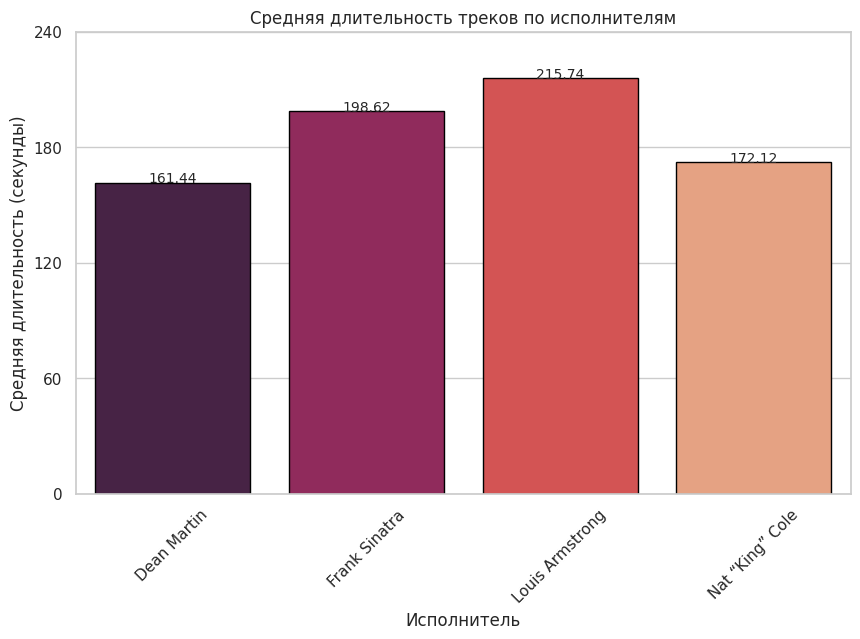

In [126]:
import numpy as np


max_duration = dur_df['mean_duration'].max()


plt.figure(figsize=(10, 6))
sns.barplot(
    data=dur_df, # Определяем откуда будут использоваться данные
    x='artist',
    y='mean_duration',
    hue='artist',  # группируем данные по категориальной переменной dur_df['artist']
    palette='rocket',
    edgecolor='black',
    legend=False
)
# P.S. Вообще аргумент 'hue' здесь избыточен, но поскольку интерпретатор ipython выдавал Future Warnings было принято решение оставить его.

plt.title("Средняя длительность треков по исполнителям")
plt.xlabel("Исполнитель")
plt.ylabel("Средняя длительность (секунды)")
plt.xticks(rotation=45)
plt.yticks(np.arange(0, max_duration + 60, 60)) # Определяем диапазон для оси Y с шагом 60 для большей наглядности

# Добавление аннотаций
for index, row in dur_df.iterrows():
    plt.text(
        index,
        row['mean_duration'] + 0.1,
        f"{row['mean_duration']:.2f}",
        ha='center',
        fontsize=10
    )

plt.show()